# Some ideas for DoE Tests Version 3
# Using the distributed data to make the DoE test with wavelengthshifts only

In [1]:
import math

import luxpy as lx
import numpy as np
from matplotlib import pyplot
import seaborn as sns
import pandas as pd

# temp import only
from empir19nrm02.tools.help import strd, label_font_size, plot_cmf2, save_fig, get_target, label_management, \
    quantil, display_responsivity, get_fig_file_name

%run -i jhelp

%matplotlib inline

from empir19nrm02.tools.help import plotCorrelation
from empir19nrm02.spectral import MCSpectrumSamples

from numpy.linalg import norm, inv
from scipy.stats import chi2

print('Version of luxpy:', lx.__version__)
out_dir = 'DoE_V3'

# comma or point as decimal separator (True--> CIE, False-->LRT)
use_comma = True
if use_comma:
    dec_sep = ','
else:
    dec_sep = '.'


Version of luxpy: v1.10.0


# Parameter for the simulation

In [2]:
wlResolution = 5
wlStart = 380
wlStop = 780
trials = 200000


In [3]:
def custom_decimal(value_str):
    # Split the string into integer and decimal parts
    integer_part, decimal_part = value_str.split('.')
    # Add spaces after every third character in the integer part
    decimal_part_formatted = " ".join([decimal_part[i:i+3] for i in range(0, len(decimal_part), 3)])
    # Join the formatted integer part with the decimal part and return the result
    formatted_value = integer_part + dec_sep + decimal_part_formatted

    return formatted_value

def custom_color(x,pos):
    value_str = f"{x:,.{4}f}"
    return custom_decimal(value_str)
def custom_color1(x,pos):
    value_str = f"{x:,.{5}f}"
    return custom_decimal(value_str)

def custom_formatter(x, pos):
    # Convert the float to a string
    value_str = f"{x:,.{0}f}"

    # Split the string into integer and decimal parts
    integer_part, decimal_part = value_str.split('.')

    # Add spaces after every third character in the integer part
    decimal_part_formatted = " ".join([decimal_part[i:i+3] for i in range(0, len(decimal_part), 3)])
    # Add spaces after every third character in the integer part
    #integer_part_formatted = integer_part.replace(",", " ")
    integer_part_formatted = integer_part
    #integer_part_formatted = " ".join([integer_part[i:i+3] for i in range(0, len(integer_part), 3)])

    # Join the formatted integer part with the decimal part and return the result
    formatted_value = integer_part_formatted + dec_sep + decimal_part_formatted

    return formatted_value

In [4]:
from matplotlib import ticker
from empir19nrm02.MC import StatDataVector

x_label = 'Wavelength, $\mathbf{\lambda}$ / nm'
y_label = 'Signal $\mathbf{S}$ / A.U.'

def plotMCResult( wl, mcVarData:StatDataVector, title=None, fig = None, ax1 = None, ax2 = None, diagnumber=0):
    bFirst = False
    if not fig:
        fig, ax1 = pyplot.subplots()
        ax2 = ax1.twinx()
        color1 = 'r-'
        color2 = 'g:'
    else:
        if diagnumber == 1:
            color1 = 'r-'
            color2 = 'g:'
        else:
            color1 = 'r--'
            color2 = 'g-.'

    if not title:
        title = ''
    ax1.plot(wl, mcVarData.v_mean/np.max(mcVarData.v_mean), color1, label= title + ' $S_{\mathrm{rel}}(\lambda)$')
    ax2.plot(wl,mcVarData.v_std / mcVarData.v_mean, color2, label= title + ' $u_{\mathrm{rel}}(S_{\mathrm{rel}})(\lambda)$')
    ax1.set_xlabel(x_label,fontsize=label_font_size)
    ax1.set_ylabel(y_label, color = 'red',fontsize=label_font_size)
    ax2.set_ylabel('$\sigma_{\mathrm{rel}}$', color = 'green',fontsize=label_font_size)
    if title:
        ax1.set_title(title)
    ax2.yaxis.set_major_formatter(ticker.FuncFormatter(custom_color))
    fig.legend(bbox_to_anchor=(.6,.6), loc="upper left", frameon=False, fontsize=label_font_size)
    return fig, ax1, ax2

Integral data: CCT: [[4.1026e+03]] K, Duv: [[-5.4294e-04]]


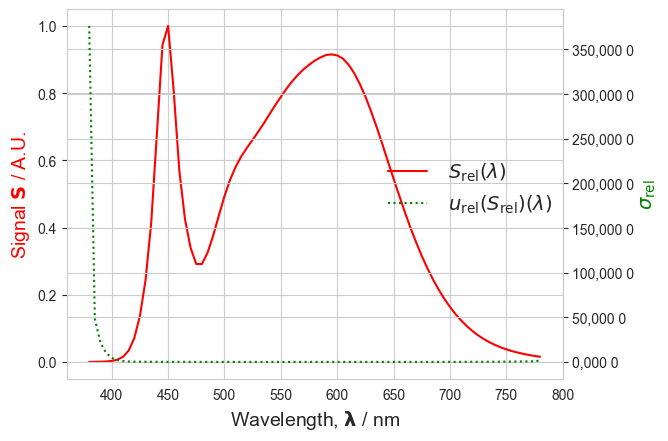

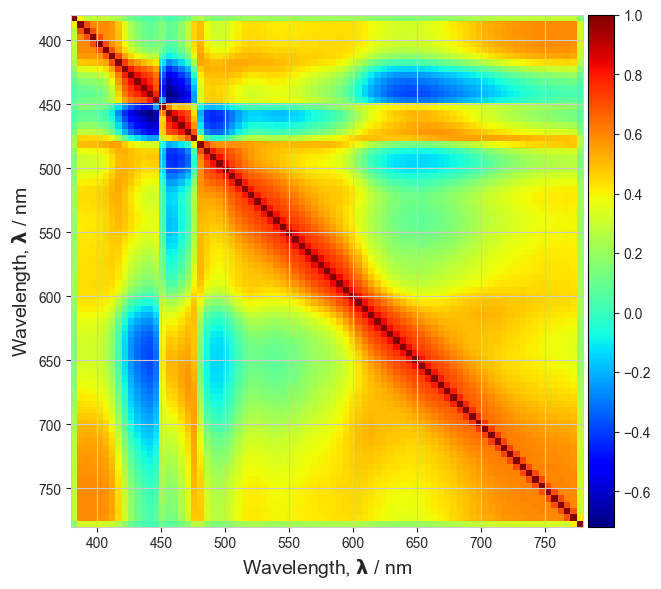

In [5]:
from empir19nrm02.MC import load_from_excel, load_from_csv
from empir19nrm02.spectral.spectral_data import _CORR_PATH
from glob import glob

# this file contains the data for the DoE test in the CORR_PATH of the package
file_list = glob(_CORR_PATH + "DoE_Test.csv", recursive = False)
for file in file_list:
    if 'xls' in file:
        wlLED, mcVectorVarLED = load_from_excel(filename= file, wlColumn = 1, valColumn=2, stdColumn = 3, covColumn=None, corrColumn = 4, startRow=2)
    else:
        wlLED, mcVectorVarLED = load_from_csv(filename= file)
        wlLED, mcVectorVarLED2 = load_from_csv(filename= file)
        XYZ_FEL = lx.spd_to_xyz(np.vstack((wlLED, mcVectorVarLED.setData.v_mean)), relative=False)
        CCT_FEL, duv_FEL = lx.xyz_to_cct(XYZ_FEL, out = 'cct,duv')
        print( f"Integral data: CCT: {CCT_FEL} K, Duv: {duv_FEL}")

    fig, ax1, ax2 = plotMCResult(wlLED, mcVectorVarLED.setData)
    save_fig(out_dir, filename='LED')
    #fig.legend(bbox_to_anchor=(1,1), loc="upper left")
    plotCorrelation(mcVectorVarLED.setData.corr_matrix, wlLED, '', x_label=x_label, y_label=x_label)
    save_fig(out_dir, filename='CorrLED')

# To show waht happens with lower number of trials

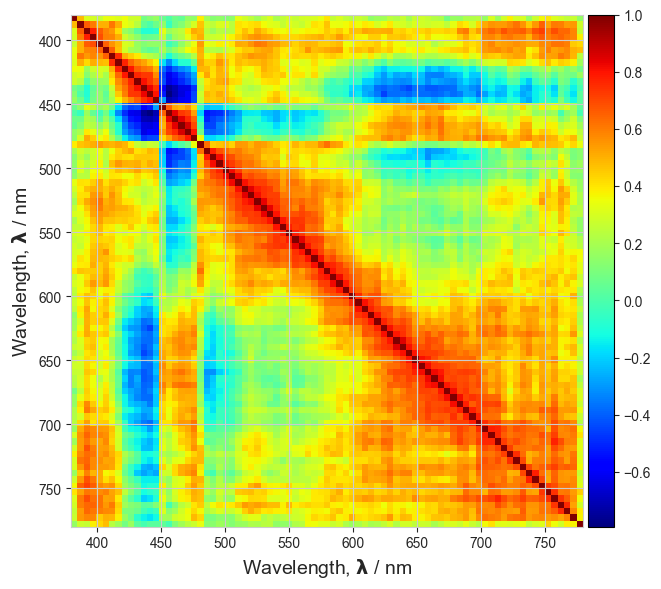

In [6]:
mcVectorVarLED2.generate_numbers(trials=100)
plotCorrelation(mcVectorVarLED2.runData.corr_matrix, wlLED, '', x_label=x_label, y_label=x_label)


# generate the random numbers from the input data

In [7]:
mcVectorVarLED.generate_numbers(trials=trials)
mcVectorVarLED2.generate_numbers(trials=trials)


In [8]:
def calcMeanCov(mcSpectrumSamples_loc):
    spec = np.vstack((wlLED, mcSpectrumSamples_loc.val))
    XYZ = lx.spd_to_xyz(spec, relative=False)
    Yxy = lx.xyz_to_Yxy(XYZ)
    x1 = np.array((np.mean(Yxy[:,1]),np.mean(Yxy[:,2])))
    cov1 = np.cov(np.array((Yxy[:,1],Yxy[:,2])))
    return x1, cov1

x1, cov1 = calcMeanCov(mcVectorVarLED)
x2, cov2 = calcMeanCov(mcVectorVarLED2)

print( x1, cov1)
print( x2, cov2)

[3.7572e-01 3.7262e-01] [[7.9555e-06 5.1969e-06]
 [5.1969e-06 9.7228e-06]]
[3.7572e-01 3.7261e-01] [[7.9991e-06 5.2303e-06]
 [5.2303e-06 9.7549e-06]]


In [9]:
# THX: https://stackoverflow.com/questions/7965743/how-can-i-set-the-aspect-ratio-in-matplotlib
def aspectratio_to_one( ax):
    ratio = 1.0
    x_left, x_right = ax.get_xlim()
    y_low, y_high = ax.get_ylim()
    ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

In [10]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

# THX: https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, fill=False, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

Evaluation according to Zeier
https://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.513.2806

* multi variate degree of equivalence $\boldsymbol{d}_{i}$ is a vector of dimension $m$
* assuming an $m$-variate normal distribution
* $mxm$ covariance matrix
* confidence region around $\boldsymbol{d}_{i}$
* for $\chi_{m,\alpha}^{2}$ usually the inverse of the culmulative pdf of the $\chi^{2}$ distribution with $m$degrees of freedom for the confidence level $alpha=0.95$ is used. (Example  $\chi_{2,0.95}^{2}=6$)

* $(\boldsymbol{x}-\boldsymbol{d}_{i})^{\mathrm{T}}{\boldsymbol{V}_{\boldsymbol{d}_{i}}}^{-1}(\boldsymbol{x}-\boldsymbol{d}_{i})=\chi_{m,\alpha}^{2}$

In [11]:
def calc_multiDim_DoE( x1_, cov1_, x2_, cov2_, data_=None):
    d = x1_-x2_
    V=cov1_+cov2_
    if data_ is None:
        data_ = np.random.default_rng().multivariate_normal(d, V, 1000)
        data_ = data_.T
    # We need to use the inverse of the cumulative distribution
    df=cov1_.shape[0]
    chisquare = chi2.ppf(0.95, df=df)

    d_norm = norm(d)
    print('chisquare:', chisquare)
    print('Difference Vecotr:', d, d_norm)
    print('Resulting Covariance Matrix:',V)
    d_y = math.sqrt(1./(d.T @ inv(V) @ d)*chisquare)
    print('dy:', d_y*d_norm)
    print('DoE:', 1/d_y)
    return d, d_y, V, data_

chisquare: 5.991464547107979
Difference Vecotr: [4.9824e-06 9.3455e-06] 1.0590643282409571e-05
Resulting Covariance Matrix: [[1.5955e-05 1.0427e-05]
 [1.0427e-05 1.9478e-05]]
dy: 0.01224209524755022
DoE: 0.0008651005459648647
[4.9824e-06 9.3455e-06] 1155.9350004624944 [[1.5955e-05 1.0427e-05]
 [1.0427e-05 1.9478e-05]]


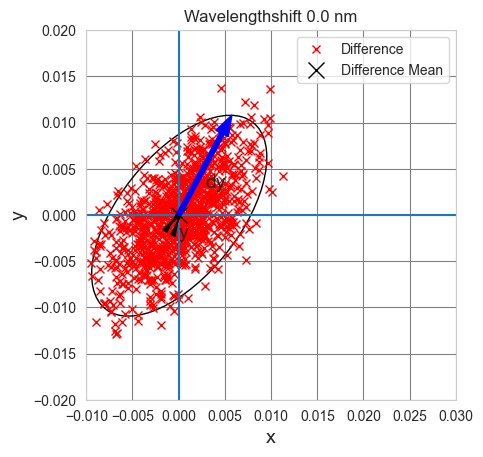

In [12]:
d, dy, V, data = calc_multiDim_DoE(x1, cov1, x2, cov2)
print( d, dy, V)

def plot_multi_DoE( fig, ax1, shift_loc, d_, dy_, V_, data_, legend=True):
    ax1.plot(data_[0], data_[1], 'rx' , label = 'Difference')
    ax1.plot(d_[0], d_[1], 'kx' , label = 'Difference Mean', markersize=12)
    confidence_ellipse(data_[0],data_[1], ax1, n_std=2.45, edgecolor='k')
    ax1.axvline(0)
    ax1.axhline(0)
    ax1.set_xlim([-0.01, 0.03])
    ax1.set_ylim([-0.02, 0.02])
    ax1.grid(color='grey')
    if legend:
        ax1.legend()
    ax1.arrow(0,0, d_[0], d_[1], width=.0005, color='black', length_includes_head=True, zorder=100)
    ax1.arrow(d_[0],d_[1], dy_*d_[0], dy_*d_[1], width=.0005, color='blue', length_includes_head=True, zorder=100)

    ax1.text(d_[0]/2, d_[1]/2-0.0025, "y",fontsize=label_font_size)
    ax1.text((dy_*d_[0]+d_[0])/2, (dy_*d_[1]+d_[1])/2-0.0025, "dy",fontsize=label_font_size)

    ax1.set_xlabel('x', fontsize=label_font_size)
    ax1.set_ylabel('y', fontsize=label_font_size)
    if legend:
        ax1.set_title(f"Wavelengthshift {shift_loc:.1f} nm")

    aspectratio_to_one(ax1)


    #save_fig(dir=out_dir, filename='2dDoE'+str(shift_loc))

fig, ax1 = pyplot.subplots()
plot_multi_DoE( fig, ax1, 0, d, dy, V, data)

In [13]:
def plot_DoE(fig, ax, shift_field, DoE_xy, DoE_md):
    ax.plot( shift_field, DoE_xy, 'rx', label='$E_n (x,y)$')
    ax.plot( shift_field, DoE_md, 'go', label='$E_n spectral$')
    ax.set_xlim([0,10])
    ax.set_xlabel('$\Delta \lambda / \mathrm{nm}$', fontsize=label_font_size)
    ax.set_ylabel('$E_n$-Score', fontsize=label_font_size)
    ax.set_xlim([0,10])
    ax.set_ylim([0,2])
    ax.hlines(1, xmin=0, xmax=10)
    ax.legend()
    #save_fig(dir=out_dir, filename='DoeSum')

# MCS
# make a wavelength shift of one of the distribtions and caculated the DoE for xy-data and the spectral inromation

0.0
chisquare: 5.991464547107979
Difference Vecotr: [-2.4073e-06 1.8470e-06] 3.03420080721285e-06
Resulting Covariance Matrix: [[1.5894e-05 1.0353e-05]
 [1.0353e-05 1.9415e-05]]
dy: 0.006551696447088399
DoE: 0.00046311681741013216
chisquare: 103.00950871222618
Difference Vecotr: [-4.7959e-05 2.3373e-05 8.0262e-05 2.5888e-05 5.4895e-05 1.1599e-05
 -1.0510e-05 -5.6669e-05 -1.3401e-04 -1.7560e-04 -2.3394e-04 -2.8484e-04
 -2.2676e-04 -1.5750e-04 1.9651e-04 4.5729e-04 2.5205e-04 8.4856e-05
 2.7532e-05 -4.1743e-06 -3.0708e-05 -4.7665e-05 -9.4086e-05 -3.5547e-05
 2.5890e-05 -6.6472e-05 2.0294e-05 -3.7330e-05 2.3556e-05 4.2930e-05
 4.8298e-05 2.6158e-05 2.9556e-05 2.4036e-05 2.1807e-05 -1.6205e-05
 -3.6051e-05 -9.0781e-06 -3.0675e-05 -5.8528e-05 -1.9439e-05 -4.6663e-05
 -8.2231e-05 -7.0694e-05 -1.8286e-05 -3.9949e-06 1.0332e-05 -5.4804e-05
 3.3497e-05 -5.3571e-05 -3.7042e-05 5.8618e-05 2.7120e-05 1.5962e-05
 3.0787e-05 9.4183e-05 -4.4660e-06 1.8810e-05 -3.9953e-05 -5.6315e-05
 -9.0170e-06 6.06

C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_2092\582228887.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig3, ax3 = pyplot.subplots()


chisquare: 5.991464547107979
Difference Vecotr: [6.2714e-03 -7.7982e-04] 0.006319704891108603
Resulting Covariance Matrix: [[1.5450e-05 1.0134e-05]
 [1.0134e-05 1.9282e-05]]
dy: 0.00734073360762002
DoE: 0.86090917187738
chisquare: 103.00950871222618
Difference Vecotr: [-2.1748e-04 -3.3922e-04 -6.5027e-04 -1.6014e-03 -3.5813e-03 -8.0342e-03
 -1.7702e-02 -3.5729e-02 -6.3199e-02 -1.0220e-01 -1.6322e-01 -2.5147e-01
 -2.5643e-01 -5.4310e-02 1.8716e-01 2.2734e-01 1.3719e-01 8.2072e-02
 4.5015e-02 1.0786e-05 -3.2033e-02 -4.8977e-02 -5.7032e-02 -5.4993e-02
 -4.6937e-02 -3.7028e-02 -3.0001e-02 -2.4036e-02 -2.3008e-02 -2.3037e-02
 -2.3978e-02 -2.5945e-02 -2.4980e-02 -2.3987e-02 -2.2965e-02 -2.1017e-02
 -1.8023e-02 -1.5998e-02 -1.3036e-02 -1.2020e-02 -9.0576e-03 -7.0757e-03
 -2.0584e-03 2.9334e-03 8.8949e-03 1.6937e-02 2.3985e-02 3.0966e-02
 3.6035e-02 4.1989e-02 4.5007e-02 4.8059e-02 5.0028e-02 4.9103e-02
 4.8070e-02 4.7019e-02 4.4925e-02 4.0978e-02 3.8986e-02 3.4889e-02
 3.1957e-02 2.9010e-02 2

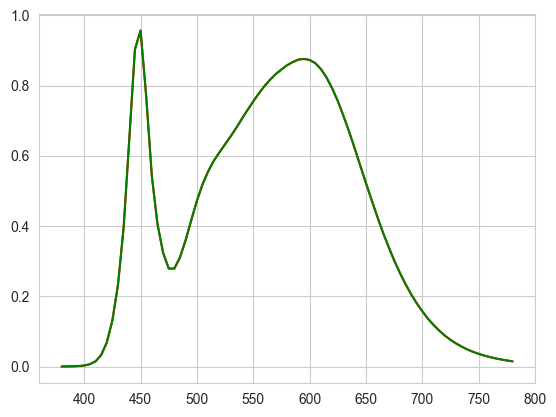

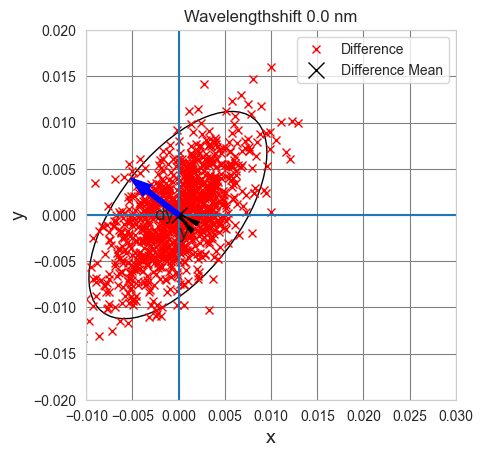

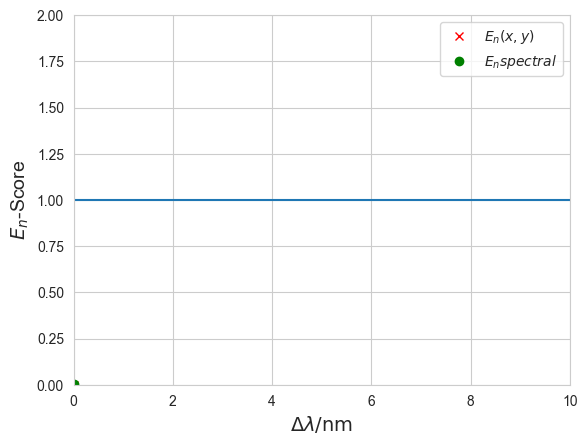

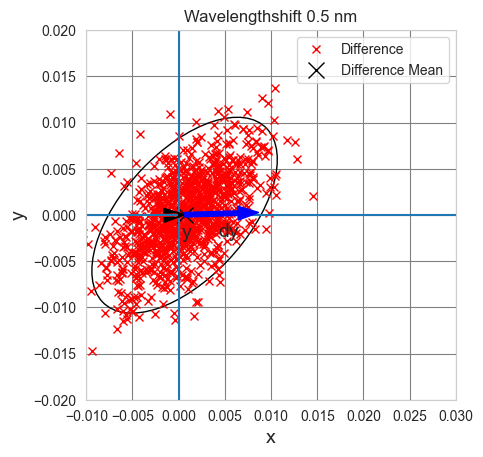

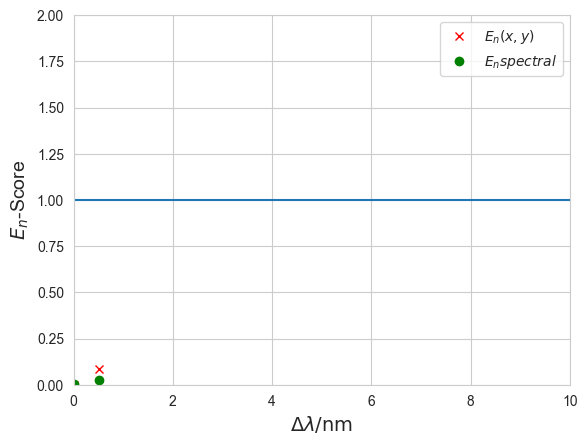

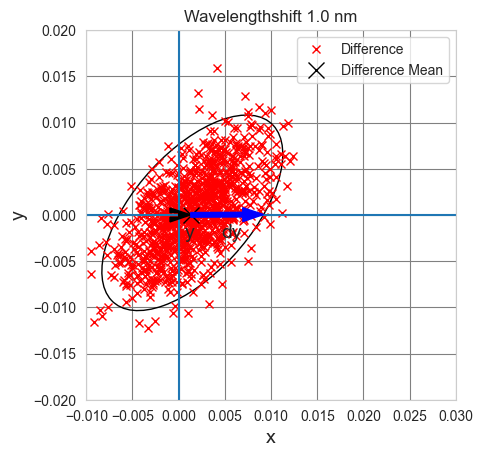

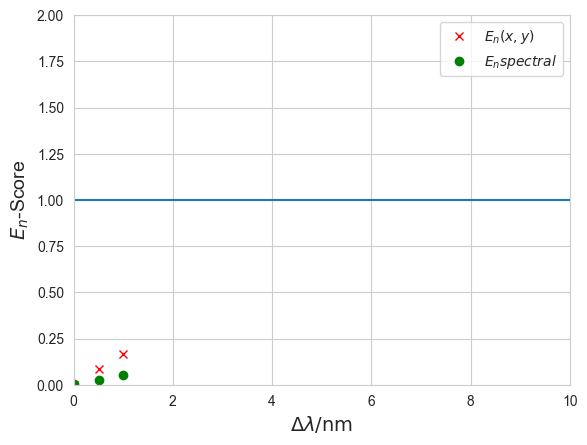

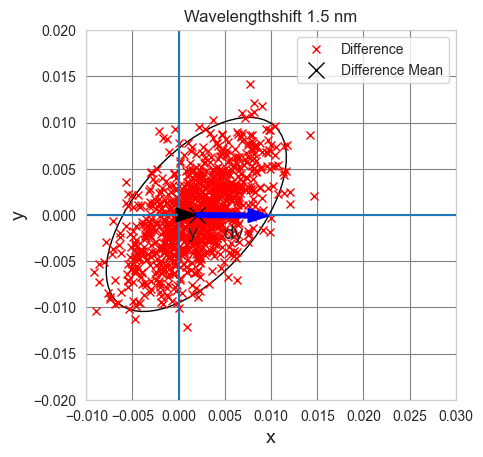

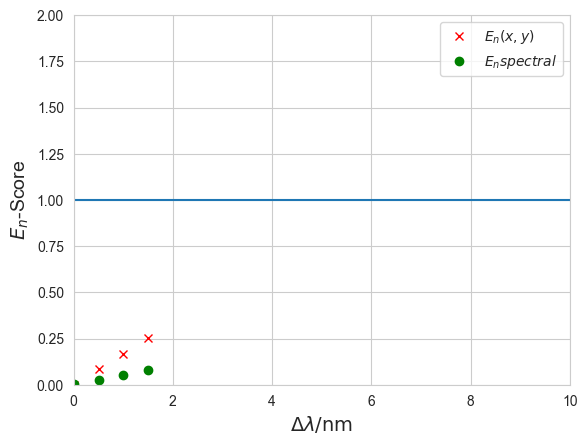

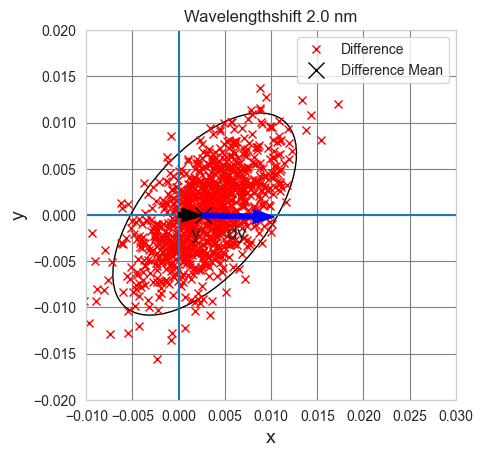

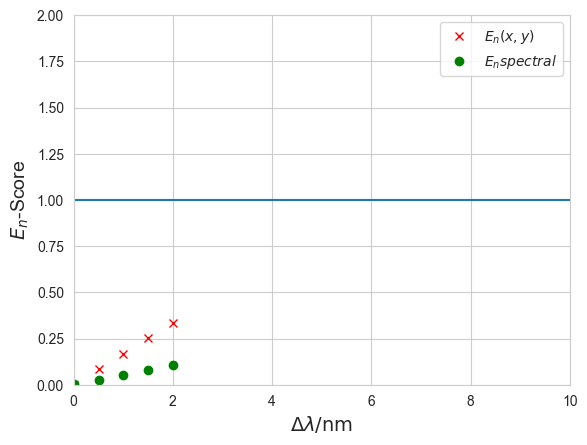

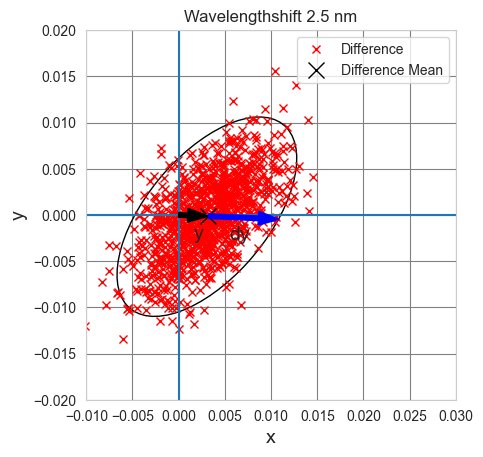

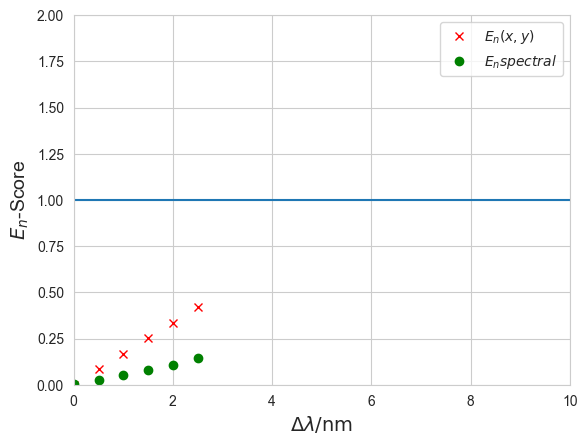

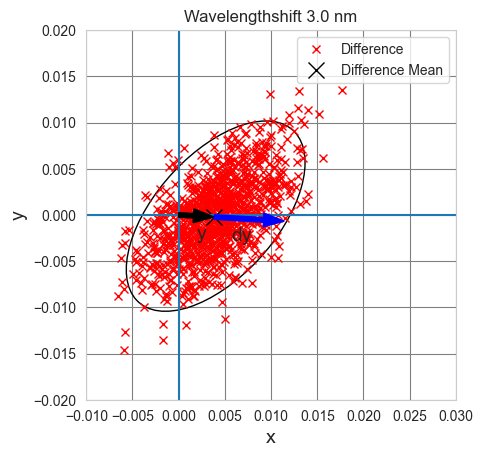

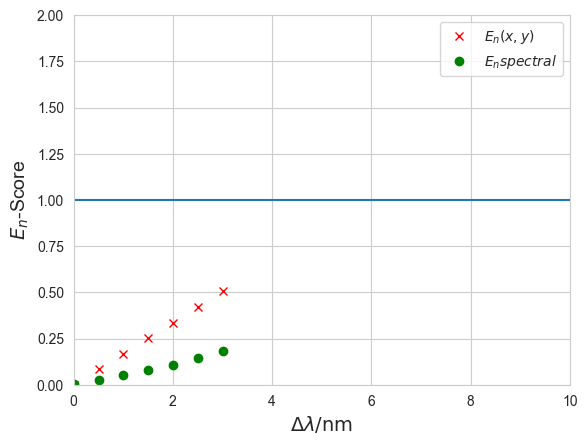

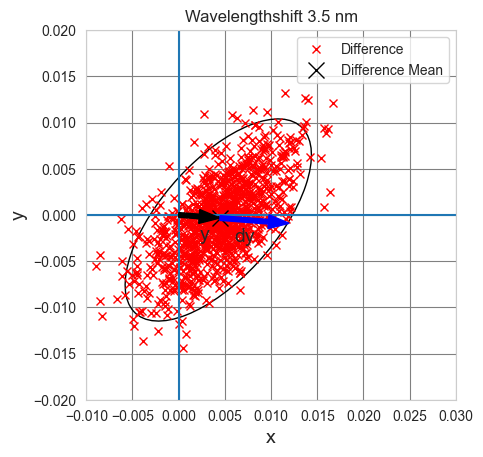

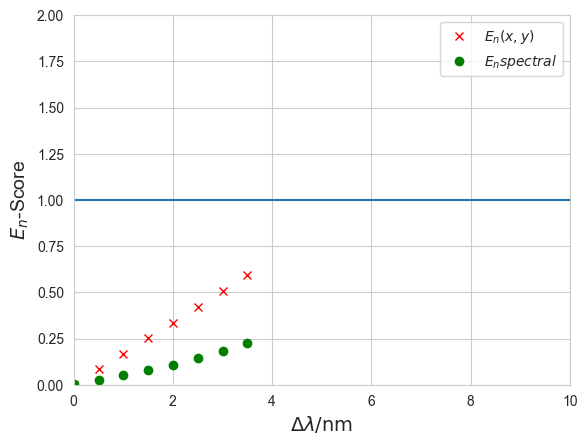

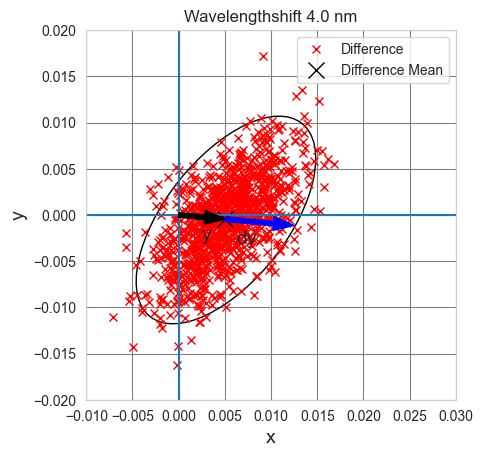

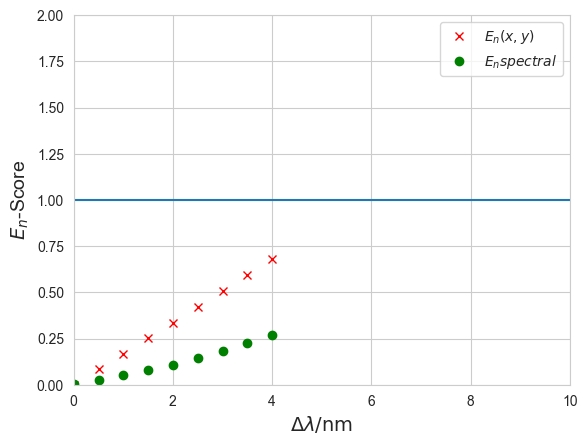

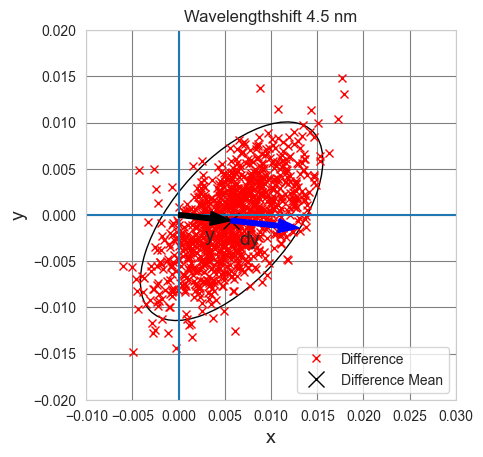

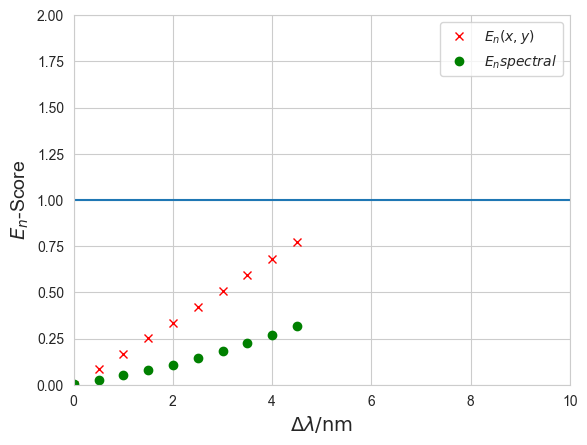

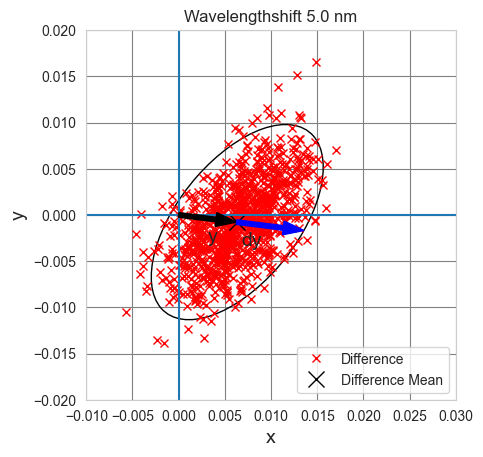

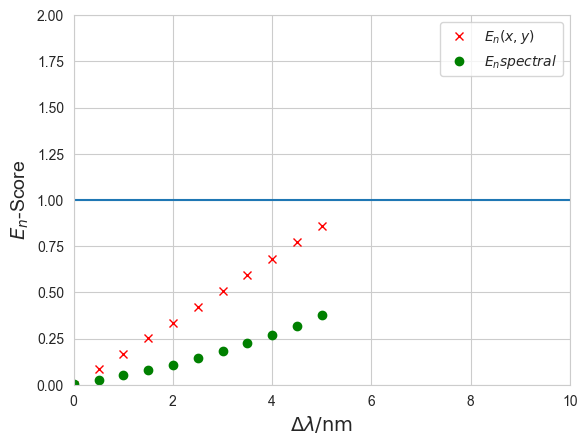

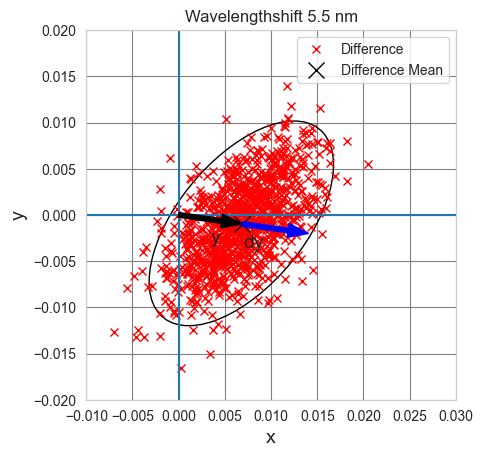

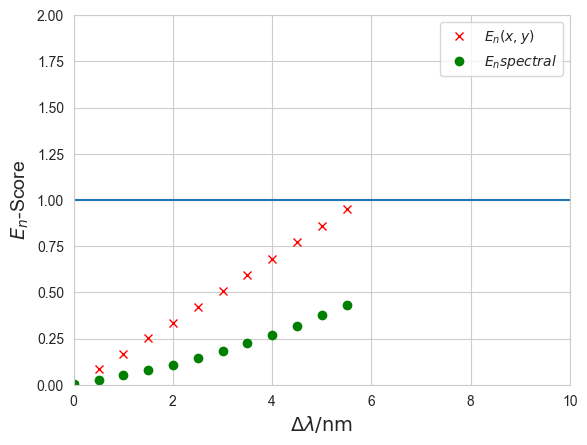

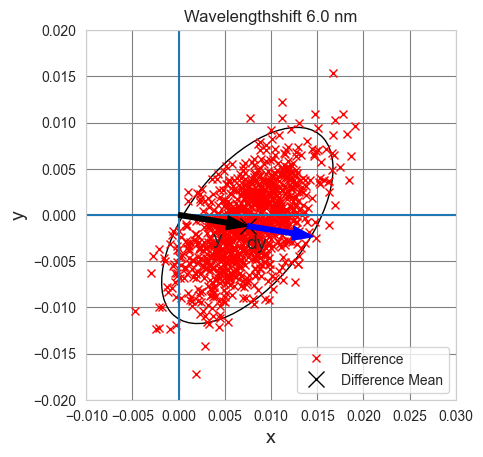

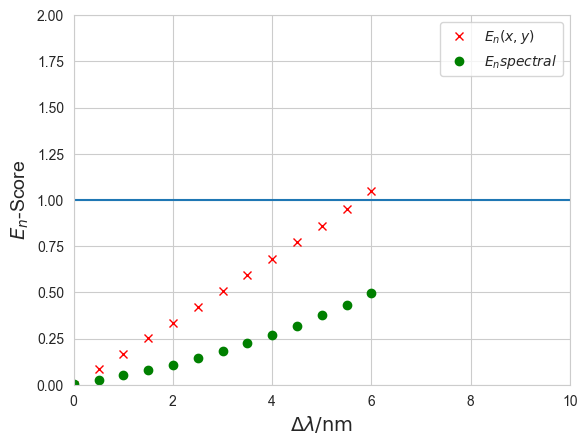

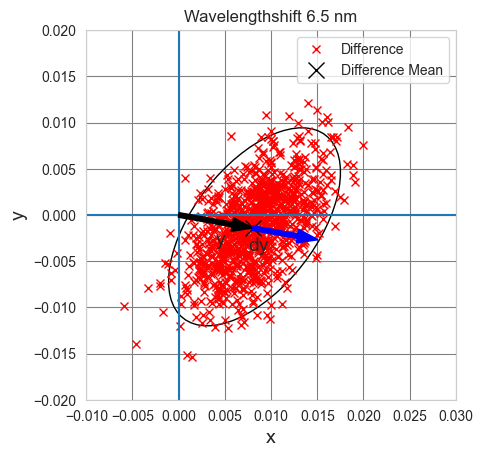

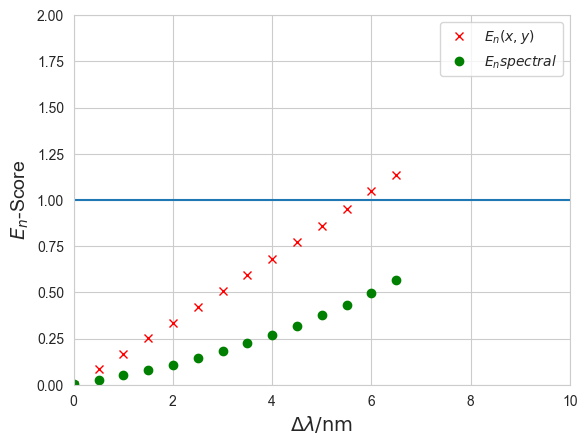

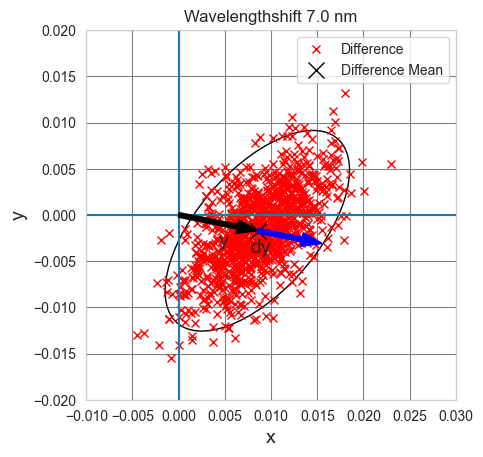

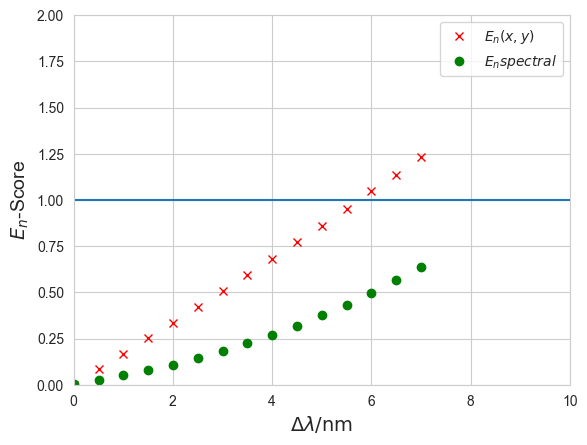

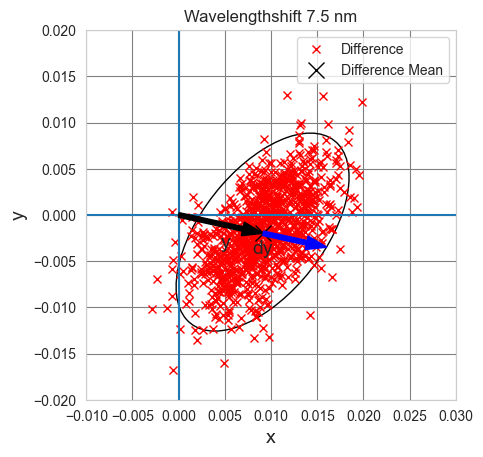

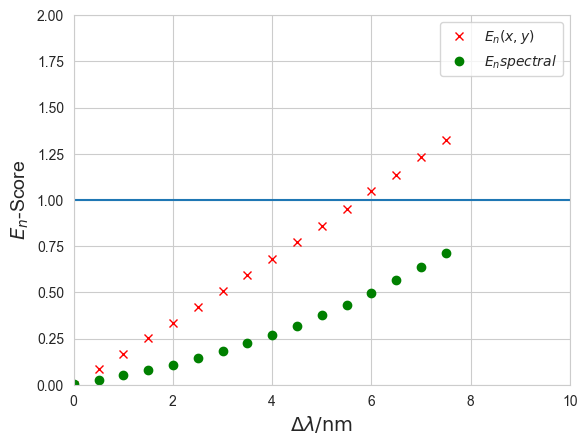

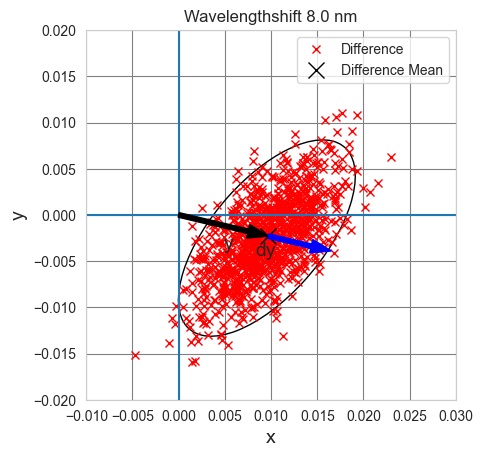

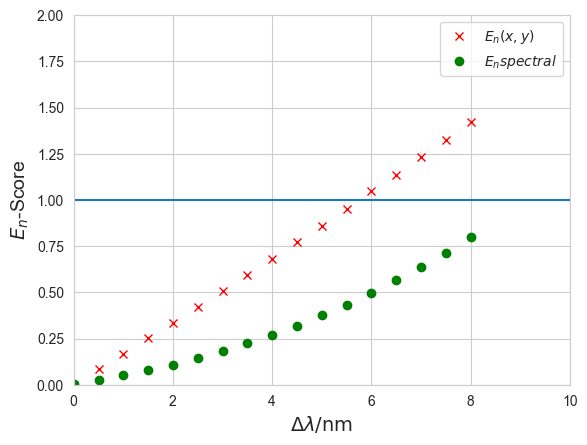

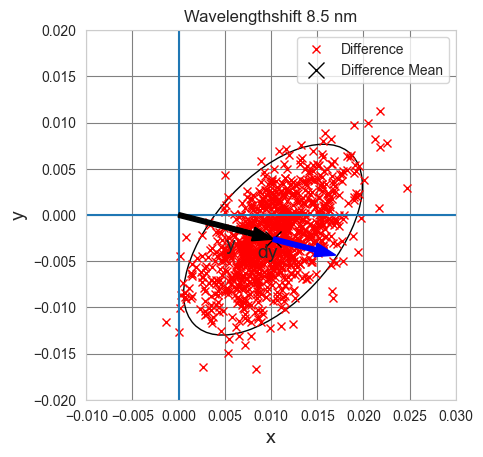

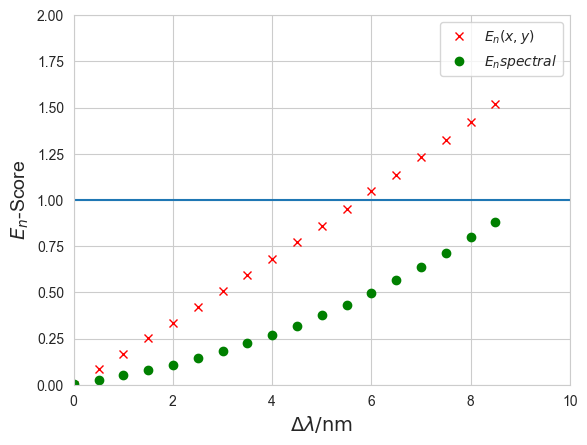

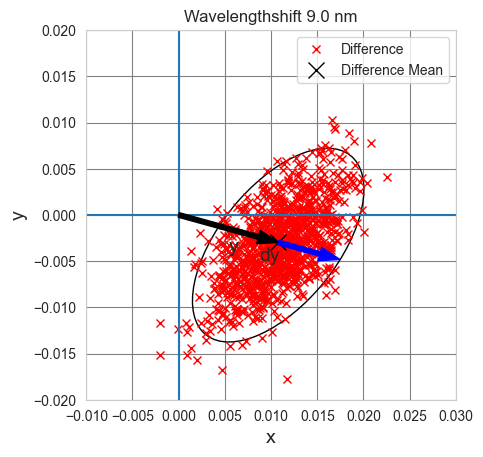

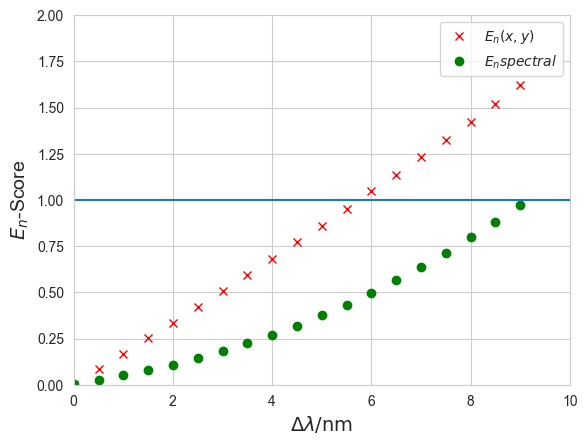

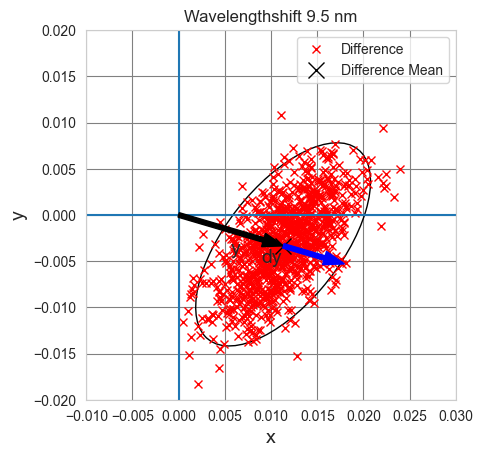

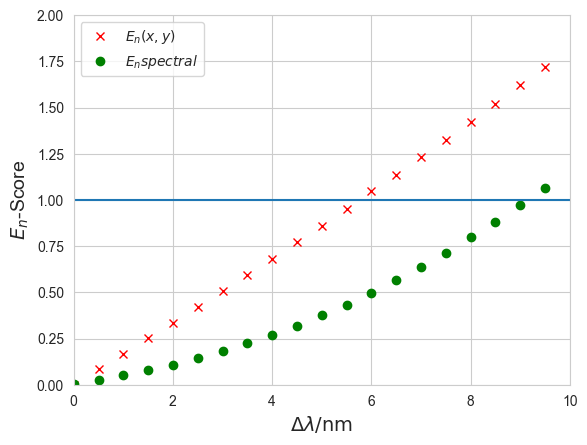

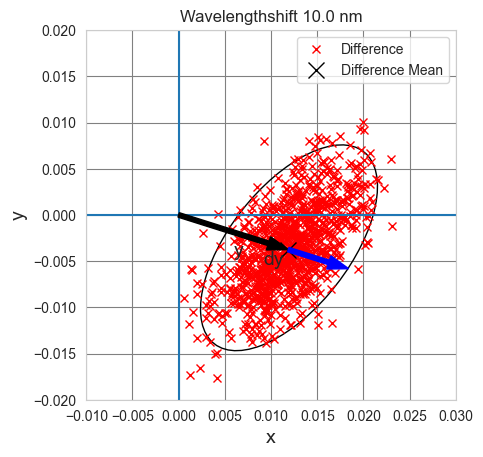

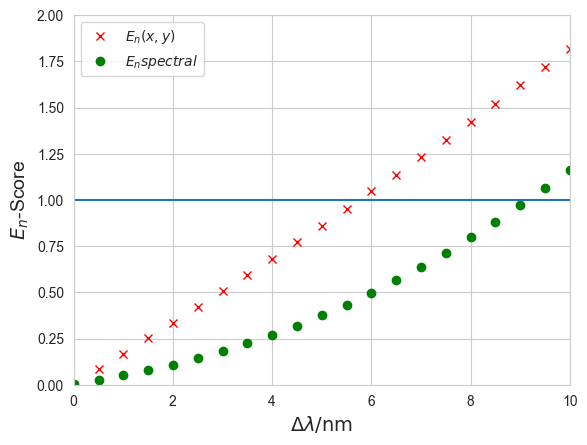

In [14]:
sample_number = 21
shift_range = 10
shift_field = np.zeros((sample_number))
DoE_xy = np.zeros((sample_number))
DoE_md = np.zeros((sample_number))

shifts = np.linspace(0, shift_range, sample_number)
res = len(wlLED)
for i, dLambdaShift in enumerate(shifts):
    shift_field[i]=dLambdaShift
    print(dLambdaShift)
    wl=wlLED.reshape(1,res)
    value=mcVectorVarLED.setData.v_mean.reshape(1,res)
    spd_init = np.r_[wl, value]
    spd_wlshift = lx.cie_interp(spd_init, \
            wl_new = dLambdaShift + wlLED,\
            kind = 'S',negative_values_allowed=True)
    mcVectorVarLED2.setData.v_mean = spd_wlshift[1]
    mcVectorVarLED2.generate_numbers(trials=trials)
    pyplot.plot(wlLED, mcVectorVarLED.setData.v_mean, 'r-')
    pyplot.plot(wlLED, mcVectorVarLED2.setData.v_mean, 'g-')

    x1, cov1 = calcMeanCov(mcVectorVarLED)
    x2, cov2 = calcMeanCov(mcVectorVarLED2)
    d, dy, V, data = calc_multiDim_DoE(x1, cov1, x2, cov2)
    fig2, ax2 = pyplot.subplots()
    plot_multi_DoE(fig2, ax2, dLambdaShift, d, dy, V, data)

    cov_image = mcVectorVarLED.runData.cov_matrix
    cov_image2 = mcVectorVarLED2.runData.cov_matrix
    sd1 = mcVectorVarLED.runData.v_mean
    sd2 = mcVectorVarLED2.runData.v_mean
    d1, dy1, V1, data1 = calc_multiDim_DoE(sd1, cov_image, sd2, cov_image2)
    DoE_xy[i] = 1/dy
    DoE_md[i] = 1/dy1
    fig3, ax3 = pyplot.subplots()
    plot_DoE( fig3, ax3, shift_field[:i+1], DoE_xy[:i+1], DoE_md[:i+1])

# save the results to an XLS-File
sumarize = np.vstack((shift_field, DoE_xy, DoE_md)).T
df = pd.DataFrame(sumarize, columns=['shift', 'DoE_xy', 'DoE_md'])
df.to_excel(get_fig_file_name(dir=out_dir, filename='DoE_Summary.xlsx', table=True))

#Ende